# Text Classification for Sentiment Analysis



## Large Movie Review Dataset
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.


http://ai.stanford.edu/~amaas/data/sentiment/

In [0]:
! pip install chazutsu

  Running setup.py bdist_wheel for chazutsu ... - \ done
  Stored in directory: /root/.cache/pip/wheels/13/8f/d3/28550e9f629b0980b790da976461fecca0319c2f2eb8996d61
Successfully built chazutsu


In [0]:
! pip install contractions

In [0]:
! pip install wordcloud

## Import libraries

In [0]:
import pandas as pd
import numpy as np

import re
import contractions

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Load the dataset
Using **chazutsu** framework. 

link: https://github.com/chakki-works/chazutsu

In [0]:
import chazutsu

In [0]:
data = chazutsu.datasets.IMDB().download()

Make directory for download at /content.
Begin downloading the Large Movie Review Dataset(IMDB) dataset from http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz.
The dataset is saved to /content/data/large_movie_review_dataset(imdb)/aclImdb_v1.tar.gz


82.2kB [00:06, 12.2kB/s]                            


Extracting pos (labeled by 1).


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]

Extracting neg (labeled by 0).



100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

Extracting unsup (labeled by None).



100%|██████████| 50/50 [00:07<00:00,  6.44it/s]

Extracting pos (labeled by 1).



100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

Extracting neg (labeled by 0).



100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Shuffle the extracted dataset.
Done all process! Make below files at /content/data/large_movie_review_dataset(imdb)
 imdb_train.txt
 imdb_unlabeled.txt
 imdb_test.txt


In [0]:
data.train_data().head(5)

,polarity,rating,review
0,0,1,Literally every aspect of this science-fiction...
1,1,10,Gerard Phillipe is absolutely perfect in this ...
2,1,10,I absolutely love this game to death. Ever sin...
3,0,1,This Movie is complete crap! Avoid this waste ...
4,0,1,I think the biggest disappointment in this fil...


In [0]:
# concatenate the two sets
texts = np.concatenate([data.train_data().review, data.test_data().review])
labels = np.concatenate([data.train_data().polarity, data.test_data().polarity])

In [0]:
# We use a random permutation np array to shuffle the text reviews.
np.random.seed(37)
perm_idx = np.random.permutation(len(texts))

texts = texts[perm_idx]
labels = labels[perm_idx]

In [0]:
# create the dataframe
col_names = ['label','text']
df = pd.DataFrame({'text':texts, 'label':labels}, columns=col_names)

In [0]:
df.head()

,label,text
0,0,Me and a friend rented this movie because it s...
1,1,"YES, the plot is hardly plausible and very thi..."
2,0,That's the sound of Stan and Ollie spinning in...
3,1,This was a great movie! Even though there was ...
4,1,Belushi at his most ingratiating and Courtney ...


## Save the raw data to a pickle
we can pickle our data or we can pickle our models with their weights so we can use them again without train them again

In [0]:
import pickle

# storing as Pickle Files
with open("df.pickle", 'wb') as f:
    pickle.dump(df,f)
    
# Unpickling the dataset
with open('df.pickle', 'rb') as f:
    df = pickle.load(f)
    
# storing as Pickle Files
with open("test_df.pickle", 'wb') as f:
    pickle.dump(test_df,f)
    
# Unpickling the dataset
with open('test_df.pickle', 'rb') as f:
    test_df = pickle.load(f)

## Are our data balanced?

In [0]:
# balanced dataset
df['label'].value_counts()

1    25000
0    25000
Name: label, dtype: int64

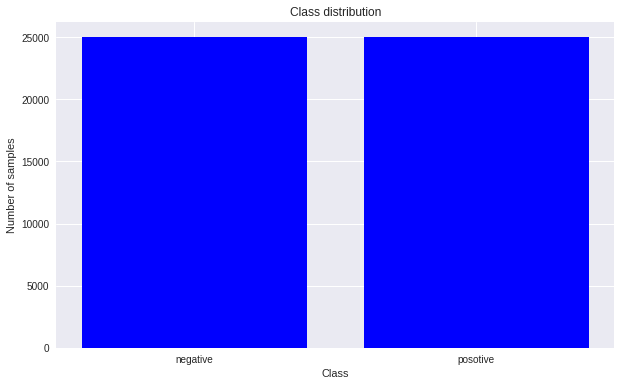

In [0]:
plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.bar([0,1], [df['label'].value_counts()[0],df['label'].value_counts()[1]], width=0.8, color='b')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution')
plt.xticks(range(2), ['negative','posotive'])
plt.show()

**NOTE:** balanced data

## Most common words of Raw data

In [0]:
rv = np.asarray(df['text'])

In [0]:
# function from google_dev
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 1),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': ngram_range,
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.rcParams["figure.figsize"] = (20.0, 10.0)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()
    


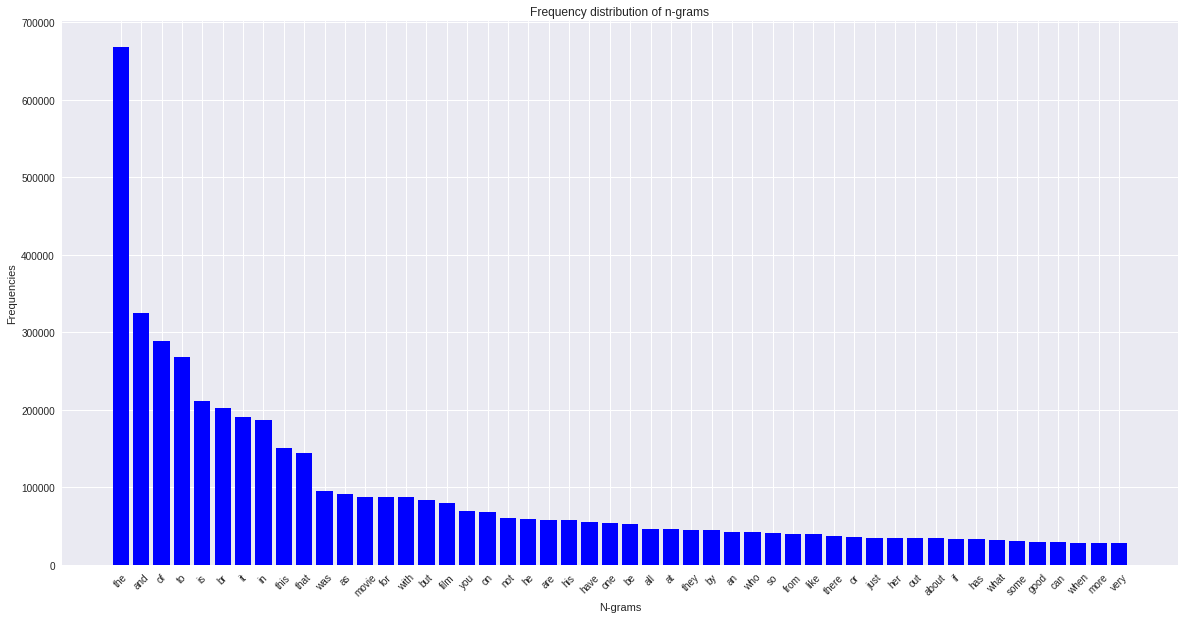

In [0]:
plot_frequency_distribution_of_ngrams(rv)

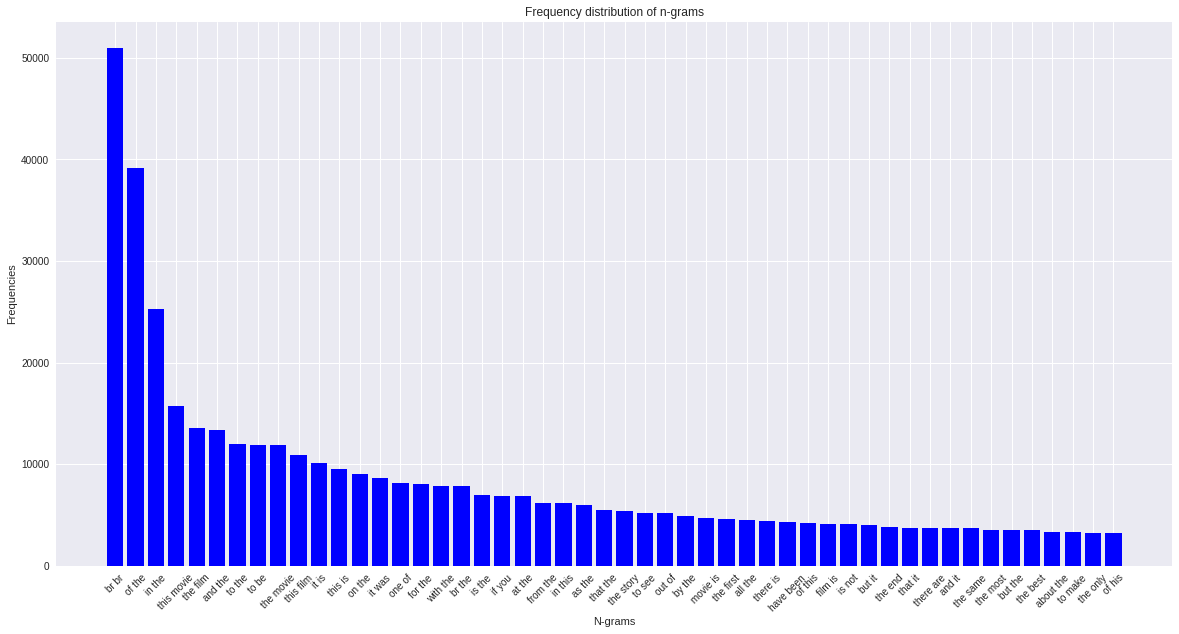

In [0]:
plot_frequency_distribution_of_ngrams(rv,ngram_range=(2, 2))

We can see that the most frequent words are the stop_words

## distribution of positive & negative reviews

In [0]:
positive = df[df['label']==1]['text']
negative = df[df['label']==0]['text']

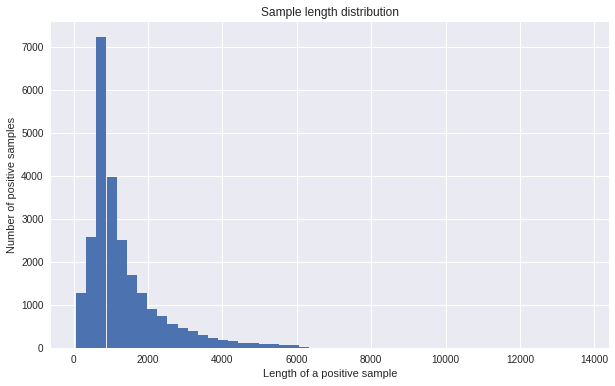

In [0]:
# Distribution of positive reviews
# length i.e. how many characters does each sample have
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    
    plt.rcParams["figure.figsize"] = (10.0, 6.0)
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a positive sample')
    plt.ylabel('Number of positive samples')
    plt.title('Sample length distribution')
    plt.show()
  
plot_sample_length_distribution(positive)

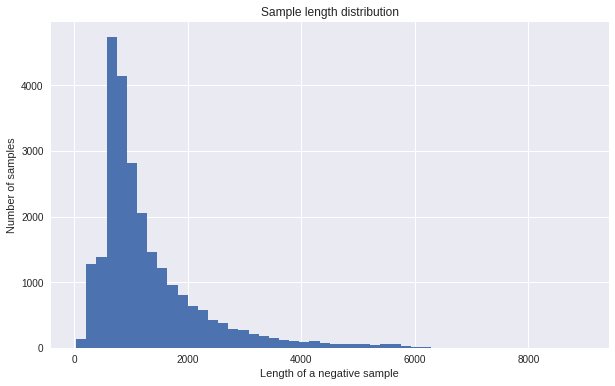

In [0]:
# Distribution of negative reviews
# length i.e. how many characters does each sample have
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    
    plt.rcParams["figure.figsize"] = (10.0, 6.0)
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a negative sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()
  
plot_sample_length_distribution(negative)

## Split the dataset to train and test set

In [0]:
train, test = train_test_split(df, stratify = df['label'], 
                                  test_size = 0.2, random_state = 82)

## Text pre-processing


*   Expanding contractions

*   Removing tags

*   Removing special characters

*   Removing stopwords

*   Remove extra letters 

*   Lemmatization with POS tagging

First let us check some examples of raw texts

In [0]:
# example of review
num_rev = 6 # number of reviews to show
for sample in range(num_rev):
    print('-'*500)
    print(df['text'][sample], 'POLARITY:', df['label'][sample])
    

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Me and a friend rented this movie because it sounded really good. But we were wrong. First of the acting....wow...the acting was the worst, the effects were really bad as well, it seemed like a film a college kid made. The plot was pretty good, but it'd been done. The thing that ruined the movies the most were the actors. The main guy was the worst actor ever...it's a shame I'm even calling him an actor...The only good thing about this movie was it was so bad it was funny...so if you want a goo

*   **Expanding contractions:** In the English language, contractions are basically shortened versions of words or syllables. These shortened versions of existing words or phrases are created by removing specific letters and sounds. Converting each contraction to its expanded, original form often helps with text standardization. Examples: don’t -> do not, I’d -> I would, he’s -> he has.

In [0]:
text = [contractions.fix(w) for w in train['text']]
test_text = [contractions.fix(w) for w in test['text']]

In [0]:
num_rev = 6 # number of reviews to show
for sample in range(num_rev):
    print('-'*500)
    print(text[sample])

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
If this movie would have been in English, all critics would have trashed it. The language is extremely bad, the scenes are awfully directed and it is not at all funny. After the movie I thought that this movie could have been written by an 8th grader, at least if you consider the lack of believable characters and the fixation on certain male body parts. (oh, on dogs as well...) The story is just plain nonsense compared to the more mature Vingar av glas that premiered almost at the same time. Of

*   **Removing links** 

*   **Removing special characters:** Special characters and symbols which are usually non alphanumeric characters often add to the extra noise in unstructured text. More than often, simple regular expressions (regexes) can be used to achieve this.

* **Remove extra letters** replace fuuuuun->fuun, goooooood->good



In [0]:
def reg_ex(corpus):
  # Use regular expressions for the preprocessing
  docum = []
  for doc in corpus:
    doc = re.sub(r"^https://t.co/[a-zA-Z0-9]*\s", " ", doc) #remove all links that appear in the beginning
    doc = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s", " ", doc)  #between 
    doc = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$", " ", doc)  # in the end of the sentence
    
    doc = re.sub('<.*?>', ' ', doc) # #substitute all <br\> with a space  
    
    doc = doc.lower()  # make all letters lower case
    
    doc = re.sub(r'(.)\1{3,}', r'\1\1', doc)  # replace fuuuuun->fuun, goooooood->good

    doc = re.sub(r"\W"," ",doc) #substitute all punctuations with a space  
    doc = re.sub(r"\d"," ",doc) #substitute all digits with a space
    doc = re.sub(r"\s+[a-z]\s+"," ",doc) #substitute all single letters in between with a space  
    doc = re.sub(r"\s+[a-z]$"," ",doc) # at the end
    doc = re.sub(r"^[a-z]\s+"," ",doc) # at the beggining

    doc = re.sub(r"\s+"," ",doc) # substitute all spaces with a single space
    doc = doc.strip()  #  characters(whitespaces) to be removed from beginning or end of the string
    docum.append(doc)
  return docum
  


In [0]:
text = reg_ex(text)
test_text = reg_ex(test_text)

In [0]:
num_rev = 6 # number of reviews to show
for sample in range(num_rev):
    print('-'*500)
    print(text[sample])

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
if this movie would have been in english all critics would have trashed it the language is extremely bad the scenes are awfully directed and it is not at all funny after the movie thought that this movie could have been written by an th grader at least if you consider the lack of believable characters and the fixation on certain male body parts oh on dogs as well the story is just plain nonsense compared to the more mature vingar av glas that premiered almost at the same time of course the publ

##Removing stopwords: 
Words which have little or no significance especially when constructing meaningful features from text are known as stopwords or stop words. These are usually words that end up having the maximum frequency if you do a simple term or word frequency in a corpus. Words like a, an, the, and so on are considered to be stopwords. There is no universal stopword list but we use a standard English language stopwords list from nltk.

In [0]:
stop_words = nltk.corpus.stopwords.words('english')

# we can see that the word 'not' is in stop_words
'not' in stop_words

True

Note: the word 'not' contains usefull information so we will keep it

In [0]:
# maybe 'not' will be usefull for the n-grams so we will keep it
for i, w in enumerate(stop_words):
  if w == 'not':
    del stop_words[i]
    
# we removed 'not' from stop words
'not' in stop_words

False

In [0]:
def remove_stopwords(doc):
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc
  
text = [remove_stopwords(w) for w in text]

test_text = [remove_stopwords(w) for w in test_text]

In [0]:
num_rev = 6 # number of reviews to show
for sample in range(num_rev):
    print('-'*500)
    print(text[sample])

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
movie would english critics would trashed language extremely bad scenes awfully directed not funny movie thought movie could written th grader least consider lack believable characters fixation certain male body parts oh dogs well story plain nonsense compared mature vingar av glas premiered almost time course public chose jalla jalla vingar av glas got little attention really disturbing fact movie looked really bad probably due fact first time director josef fares used really cheap camera equi

## Lemmatization

**Note:** We also have to specify the parts of speech of the word in order to get the correct lemma. Words can be in the form of Noun(n), Adjective(a), Verb(v), Adverb(r). Therefore, first we will get the POS of a word before we lemmatize it.

In [0]:
# Lemmatize with POS Tag
import nltk
from nltk.corpus import wordnet  # To get words in dictionary with their parts of speech
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
# create a dataframe for the processsed data
prepDF = pd.DataFrame(text, columns=['text'])
pre_testpDF = pd.DataFrame(test_text, columns=['text'])

In [0]:
# function from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [0]:
w_tokenizer = nltk.tokenize.word_tokenize
wnl = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [wnl.lemmatize(w, get_wordnet_pos(w)) for w in w_tokenizer(text)]

In [0]:
import time
start = time.time()
prepDF['text_lemmatized'] = prepDF['text'].apply(lemmatize_text)
print ("training time:", time.time() - start, "s") 

start = time.time()
pre_testpDF['text_lemmatized'] = pre_testpDF['text'].apply(lemmatize_text)
print ("training time:", time.time() - start, "s") 

training time: 1032.398239850998 s
training time: 260.0877923965454 s


In [0]:
# each line is a review
prepDF['text_lemmatized_sent'] = np.asarray([' '.join(prepDF['text_lemmatized'][i]) for i in range(len(prepDF['text_lemmatized']))])
pre_testpDF['text_lemmatized_sent'] = np.asarray([' '.join(pre_testpDF['text_lemmatized'][i]) for i in range(len(pre_testpDF['text_lemmatized']))])


## Pickle the processed data

In [0]:
prepDF['label'] = np.array(train['label'])
pre_testpDF['label'] = np.array(test['label'])

In [0]:
prepDF = prepDF.drop(['text', 'text_lemmatized'], axis=1)
pre_testpDF = pre_testpDF.drop(['text', 'text_lemmatized'], axis=1)

In [0]:
# storing as Pickle Files
with open("prepDF.pickle", 'wb') as f:
    pickle.dump(prepDF,f)

In [0]:
# storing as Pickle Files
with open("prep_testDF.pickle", 'wb') as f:
    pickle.dump(pre_testpDF,f)

In [0]:
prepDF.head()

,text_lemmatized_sent,label
0,movie would english critic would trash languag...,0
1,hard believe cast strong one movie dud incredi...,0
2,anatomy german film producer try make somethin...,1
3,watch trailer dvd see film think anyone saw wa...,1
4,film go bad film ever make file copy film watc...,0


In [0]:
# Unpickling the dataset
with open('prepDF.pickle', 'rb') as f:
    prepDF = pickle.load(f)

In [0]:
# Unpickling the dataset
with open('pre_testpDF.pickle', 'rb') as f:
    pre_testpDF = pickle.load(f)

## WordCloud Visualization

In [0]:
negative = prepDF[prepDF['label']==0]['text_lemmatized_sent']
positive = prepDF[prepDF['label']==1]['text_lemmatized_sent']

In [0]:
pos_words = [' '.join(nltk.word_tokenize(t)) for t in positive]
pos_words= ' '.join(pos_words)

In [0]:
neg_words = [' '.join(nltk.word_tokenize(t)) for t in negative]
neg_words= ' '.join(neg_words)

In [0]:
from wordcloud import WordCloud

# Generate a word cloud image
pos_wordcloud = WordCloud(width=600, height=400).generate(pos_words)
neg_wordcloud = WordCloud(width=600, height=400).generate(neg_words)

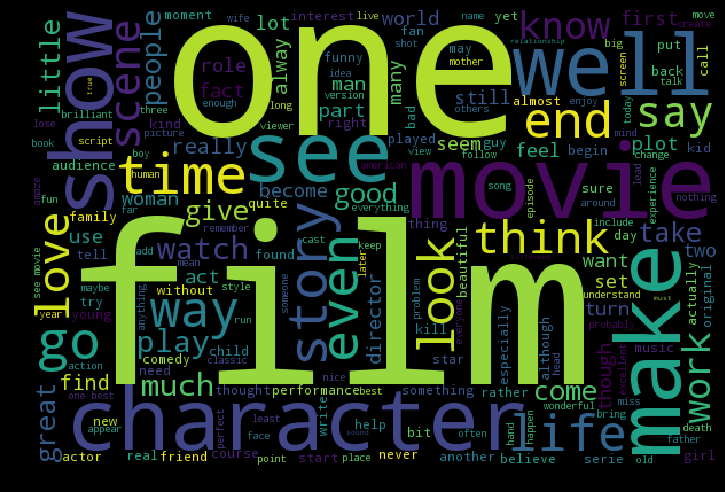

In [0]:
#positive Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


This wordcloud illustrates that most frequent words for positive reviews are: good, love, well, great that have a positive meaning. Moreover it shows a lot neutral words like: film, movie, one, see, show

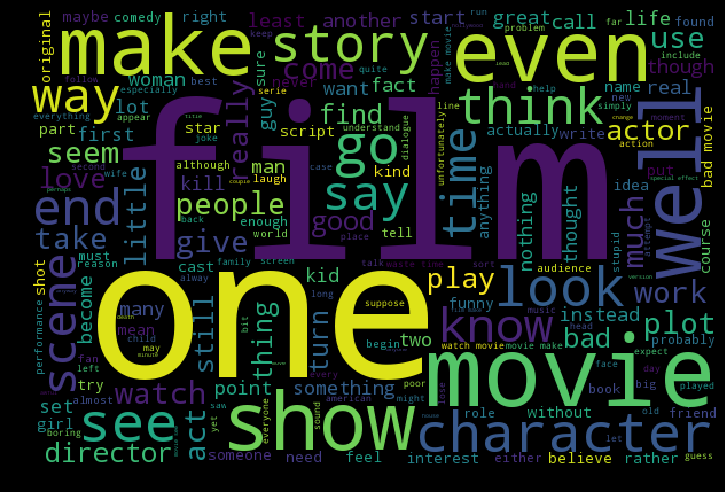

In [0]:
#neg word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [0]:
train_x = prepDF['text_lemmatized_sent']
test_x = pre_testpDF['text_lemmatized_sent']
train_y = prepDF['label']
test_y = pre_testpDF['label']

# Building Basic Models

In [0]:
# import the evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report

In [0]:
import time

## Bag Of Words
we use  **word counts** as features.  using CountVectorizer from scikit-learn.

* max_features=2000: use the 2000 most frequent words as features
* min_df=3: remove all the words that appear in less than 3 documents (really weird-useless words)
* max_df=0.6: remove all the words that appear in more than 60% of the documents i.e. 'the', 'is' etc
* ngram_range: use 1-gram and 2-gramsngram_range=(1, 2)
* analyzer ='word': the feature should be made of word n-grams.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

ctv = CountVectorizer(max_features=2000,min_df=3, max_df=0.6, analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2))

start = time.time()
# Fitting Count Vectorizer 
xtrain_ctv = ctv.fit_transform(train_x)
xtest_ctv  = ctv.transform(test_x)
print ("transform time:", time.time() - start, "s") 

transform time: 26.35229182243347 s


### Use Logistic Regression to CountVectorizer featured data 

### quick selection of C value
Inverse of regularization strength, i.e. 1/C regularization strength

In [0]:
from sklearn.linear_model import LogisticRegression

for c in [0.001, 0.05, 0.01, 0.1, 1]:
    
    clf = LogisticRegression(C=c, penalty='l2')
    clf.fit(xtrain_ctv, train_y)
    print ("f1_score for C=%s: %s" 
           % (c, f1_score(test_y, clf.predict(xtest_ctv), 
                          pos_label=1, average='binary')))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1_score for C=0.001: 0.8647376164786661
f1_score for C=0.05: 0.884306533161495
f1_score for C=0.01: 0.8836381611468117
f1_score for C=0.1: 0.8838869608329202
f1_score for C=1: 0.8818913281017186


In [0]:
clf_lr = LogisticRegression(C=0.05, penalty='l2')

start = time.time()
clf_lr.fit(xtrain_ctv, train_y)
print ("training time:", time.time() - start, "s") 

start = time.time()
predictions = clf_lr.predict(xtest_ctv)
print ("predict time:", time.time() - start, "s") 

lg = log_loss(test_y, predictions, eps=1e-15)*0.1
f1 = f1_score(test_y, predictions, pos_label=1, average='binary')

print ("logloss: %0.3f " % lg)
print ("f1_score: %0.3f " % f1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


training time: 2.0228068828582764 s
predict time: 0.003972053527832031 s
logloss: 0.403 
f1_score: 0.884 


### Let's see the 20 most important features for positive and negative polarity separately; using the  final model with features from CountVectorizer 

In [0]:
feature_to_coef = {word: coef for word, 
                   coef in zip(ctv.get_feature_names(), clf_lr.coef_[0])}

print("BEST POSITIVE WORDS")   
sorted(feature_to_coef.items(),key=lambda x: x[1],reverse=True)[:20]

BEST POSITIVE WORDS


[('excellent', 0.89377442094473),
 ('superb', 0.8543879624470869),
 ('hilarious', 0.7534164544118062),
 ('well worth', 0.7354635346752573),
 ('amaze', 0.723249840019743),
 ('one best', 0.7079982918265139),
 ('highly recommend', 0.6997437872509358),
 ('wonderfully', 0.6972979010200727),
 ('funniest', 0.6922295444491906),
 ('must see', 0.6846388877125653),
 ('solid', 0.6806544483629094),
 ('fantastic', 0.6805852777801313),
 ('wonderful', 0.6722229634418992),
 ('enjoyable', 0.6613654892862211),
 ('outstanding', 0.6569081966502914),
 ('beautifully', 0.6515345819104409),
 ('perfect', 0.6433565984939087),
 ('favorite', 0.6293651687787521),
 ('subtle', 0.6271381426634789),
 ('gem', 0.6173417640073777)]

In [0]:
print("BEST NEGATIVE WORDS")    
sorted(feature_to_coef.items(),key=lambda x: x[1])[:20]

BEST NEGATIVE WORDS


[('awful', -1.1999820964884753),
 ('not recommend', -1.1456004756848275),
 ('not funny', -1.0193068455887253),
 ('not worth', -1.013496226323261),
 ('waste', -0.9809505222663807),
 ('disappointment', -0.95452163062033),
 ('laughable', -0.9196965292583373),
 ('poorly', -0.9027700527446442),
 ('fails', -0.8433027338381475),
 ('dull', -0.8414659869002917),
 ('boring', -0.8371692123983565),
 ('unfunny', -0.8252199907078347),
 ('terrible', -0.7908267452850906),
 ('pointless', -0.7537693088719354),
 ('mediocre', -0.7265367449855787),
 ('horrible', -0.7128856989910636),
 ('redeem', -0.7086867667631237),
 ('not good', -0.6991653552086862),
 ('one bad', -0.694248911733288),
 ('embarrass', -0.679940474289303)]

## Tf-Idf
Term Frequency - Inverse Document Frequency <br>
**Equivalent** to CountVectorizer followed by TfidfTransformer.
we use  **word counts** as features.  using CountVectorizer from scikit-learn.



In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(strip_accents='unicode', min_df=3, max_df=0.9, analyzer='word', 
                      token_pattern=r'\w{1,}', ngram_range=(1, 2), use_idf='True',
                      smooth_idf=1,sublinear_tf=1)
start = time.time()
# Fitting TF-IDF to both training and test sets (semi-supervised learning)
train_x_tfv = tfv.fit_transform(train_x)
test_x_tfv  = tfv.transform(test_x)
print ("transform time:", time.time() - start, "s") 

transform time: 31.121902227401733 s


### Use Logistic Regression to Tf-Idf featured data 

### Quick selection of C value

In [0]:
for c in [0.1, 1, 10]:
    
    clf = LogisticRegression(C=c, penalty='l2')
    clf.fit(train_x_tfv, train_y)
    print ("f1_score for C=%s: %s" 
           % (c, f1_score(test_y, clf.predict(test_x_tfv), pos_label=1, average='binary')))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1_score for C=0.1: 0.8774231447033484
f1_score for C=1: 0.9043564356435644
f1_score for C=10: 0.9143254244018664


**NOTE:** The C value: inverse regularization strength

In [0]:
clf_lr = LogisticRegression(C=10, penalty='l2')

start = time.time()
clf_lr.fit(train_x_tfv, train_y)
print ("training time:", time.time() - start, "s") 

start = time.time()
predictions = clf_lr.predict(test_x_tfv)
print ("predict time:", time.time() - start, "s") 

lg = log_loss(test_y, predictions, eps=1e-15)*0.1
f1 = f1_score(test_y, predictions, pos_label=1, average='binary')

print ("logloss: %0.3f " % lg)
print ("f1_score: %0.3f " % f1)  
print ("accuracy_score: %0.3f " % accuracy_score(test_y, predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


training time: 4.673572063446045 s
predict time: 0.007370471954345703 s
logloss: 0.298 
f1_score: 0.914 
accuracy_score: 0.914 


In [0]:
feature_to_coef = {word: coef for word, 
                   coef in zip(tfv.get_feature_names(), clf_lr.coef_[0])}
print("BEST POSITIVE WORDS")   
sorted(feature_to_coef.items(),key=lambda x: x[1],reverse=True)[:20]

BEST POSITIVE WORDS


[('great', 14.152062762221778),
 ('excellent', 14.051148282806482),
 ('perfect', 10.545834343657138),
 ('wonderful', 10.308914405155807),
 ('amaze', 10.060658065147067),
 ('favorite', 9.273504654134971),
 ('enjoy', 9.142594374073452),
 ('hilarious', 8.948712129401978),
 ('superb', 8.708167608342407),
 ('fun', 8.642238832151522),
 ('brilliant', 8.52398146774328),
 ('one best', 8.392374086515344),
 ('love', 8.196199429504377),
 ('today', 8.106200483687795),
 ('best', 8.039891313774023),
 ('enjoyable', 7.557903339022633),
 ('well worth', 7.407415717988514),
 ('highly recommend', 7.38663600949351),
 ('must see', 7.3467139604061344),
 ('fantastic', 7.171110454813434)]

In [0]:
print("BEST NEGATIVE WORDS")    
sorted(feature_to_coef.items(),key=lambda x: x[1])[:20]

BEST NEGATIVE WORDS


[('bad', -22.28814133521063),
 ('awful', -15.769010451460463),
 ('waste', -13.268007233649936),
 ('boring', -12.953849641136314),
 ('terrible', -11.56358139359979),
 ('poor', -11.070480910727273),
 ('nothing', -10.860516237207738),
 ('not recommend', -10.025400484211428),
 ('not funny', -10.005891081839998),
 ('dull', -9.84969319290178),
 ('horrible', -9.8015713152291),
 ('disappointment', -9.642023365893097),
 ('not even', -9.265854139560547),
 ('fails', -9.136465707984614),
 ('poorly', -8.944579716251326),
 ('not worth', -8.81919411084863),
 ('suppose', -8.803635990708939),
 ('stupid', -8.746961123580986),
 ('unfortunately', -8.744815902081667),
 ('lack', -8.392140721022955)]

### Naive Bayes to Tf-Idf data 

In [0]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(alpha=1)

start = time.time()
clf.fit(train_x_tfv, train_y)
print ("training time:", time.time() - start, "s") 

start = time.time()
predictions = clf.predict(test_x_tfv)
print ("predict time:", time.time() - start, "s") 

lg = log_loss(test_y, predictions, eps=1e-15)*0.1
f1 = f1_score(test_y, predictions, pos_label=1, average='binary')

print ("logloss: %0.3f " % lg)
print ("f1_score: %0.3f " % f1)

training time: 0.1568162441253662 s
predict time: 0.04813694953918457 s
logloss: 0.391 
f1_score: 0.887 


In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=7, n_estimators=400)

start = time.time()
clf.fit(train_x_tfv, train_y)
print ("training time:", time.time() - start, "s") 

start = time.time()
predictions = clf.predict(test_x_tfv)
print ("predict time:", time.time() - start, "s") 

lg = log_loss(test_y, predictions, eps=1e-15)*0.1
f1 = f1_score(test_y, predictions, pos_label=1, average='binary')

print ("logloss: %0.3f " % lg)
print ("f1_score: %0.3f " % f1)

training time: 10.58471155166626 s
predict time: 4.982880353927612 s
logloss: 0.502 
f1_score: 0.860 


### XGBoost to Tf-Idf data

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the official documentation. https://xgboost.readthedocs.io/en/latest/

In [0]:
import xgboost as xgb

clf = xgb.XGBClassifier(max_depth=7,objective='binary:logistic', n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
start = time.time()
clf.fit(train_x_tfv.tocsc(), train_y)
print ("training time:", time.time() - start, "s") 

start = time.time()
predictions = clf.predict(test_x_tfv.tocsc())
print ("predict time:", time.time() - start, "s") 

lg = log_loss(test_y, predictions, eps=1e-15)*0.1
f1 = f1_score(test_y, predictions, pos_label=1, average='binary')

print ("logloss: %0.3f " % lg)
print ("f1_score: %0.3f " % f1)

training time: 267.8807270526886 s
predict time: 0.7535176277160645 s
logloss: 0.463 
f1_score: 0.868 


## Singular Value Decomposition to the features from the TF-IDF 


In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

# Apply SVD, I chose 100 components. 100-200 components are good enough for SVM model.
svd = TruncatedSVD(n_components=100)
xtrain_svd = svd.fit_transform(train_x_tfv)
xtest_svd = svd.transform(test_x_tfv)

explained_variance = svd.explained_variance_ratio_.sum()
print("Sum of explained variance ratio: %d%%" % (int(explained_variance * 100)))
    

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
xtrain_svd_scl = scl.fit_transform(xtrain_svd)
xtest_svd_scl = scl.transform(xtest_svd)

Sum of explained variance ratio: 3%


### Support Vector Machine to SVD data

Since SVMs take a lot of time, we will reduce the number of features from the TF-IDF using Singular Value Decomposition before applying SVM.

Also, note that before applying SVMs, we must standardize the data.

In [0]:
from sklearn.svm import SVC

# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) 

start = time.time()
clf.fit(xtrain_svd_scl, train_y)
print ("training time:", time.time() - start, "s") 

start = time.time()
predictions = clf.predict(xtest_svd_scl)
print ("predict time:", time.time() - start, "s") 

lg = log_loss(test_y, predictions, eps=1e-15)*0.1
f1 = f1_score(test_y, predictions, pos_label=1, average='binary')

print ("logloss: %0.3f " % lg)
print ("f1_score: %0.3f " % f1)

**NOTE:** too slow